# Predict Bike Sharing Demand with AutoGluon Template

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [1]:
# Modified
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

In [3]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [6]:
# Create the train dataset in pandas by reading the csv
train = pd.read_csv("./train.csv")

# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train.loc[:, 'datetime'] = pd.to_datetime(train.datetime)
train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [7]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

              count  
count  10886.000000  
mean     191.574132  
std      181.144454  
min        1.000000  
25%       42.000000  
50%      145.000000  
75%      284.000000  
max      977.000000

In [8]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('./test.csv', parse_dates=["datetime"])
test.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0 2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1 2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2 2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3 2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4 2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed  
0        56    26.0027  
1        56     0.0000  
2        56     0.0000  
3        56    11.0014  
4        56    11.0014

In [9]:
# Same thing as train and test dataset
submission = pd.read_csv('./sampleSubmission.csv', parse_dates=["datetime"])
submission.head()

datetime  count
0 2011-01-20 00:00:00      0
1 2011-01-20 01:00:00      0
2 2011-01-20 02:00:00      0
3 2011-01-20 03:00:00      0
4 2011-01-20 04:00:00      0

## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

No path specified. Models will be saved in: "AutogluonModels/ag-20220906_085203/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220906_085203/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns

<AxesSubplot:xlabel='model'>

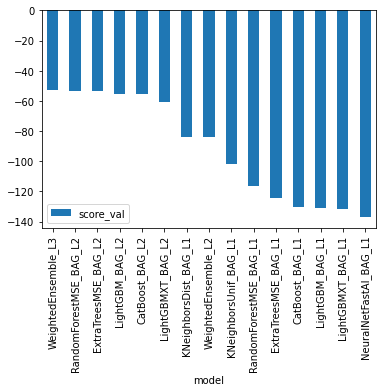

In [10]:
predictor = TabularPredictor(label="count", learner_kwargs={'ignored_columns': ["casual", "registered"]}).fit(
    train_data=train, time_limit=600, presets="best_quality"
)

# Output the model's `score_val` in a bar chart to compare performance
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

### Review AutoGluon's training run with ranking of models that did the best.

In [11]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.785956      10.591459  449.490217                0.000874           0.533883            3       True         15
1   RandomForestMSE_BAG_L2  -53.394189       9.788487  413.514198                0.596393          26.417375            2       True         12
2     ExtraTreesMSE_BAG_L2  -53.768452       9.773817  395.665666                0.581723           8.568842            2       True         14
3          LightGBM_BAG_L2  -55.114816       9.412469  413.970117                0.220375          26.873293            2       True         11
4          CatBoost_BAG_L2  -55.666961       9.278007  448.752891                0.085913          61.656068            2       True         13
5        LightGBMXT_BAG_L2  -60.567252      12.306678  440.432741         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -

### Create predictions from test dataset

In [12]:
predictions = predictor.predict(test)
predictions.head()

0    22.813011
1    40.662582
2    44.945061
3    48.760990
4    51.781357
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [13]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.532494
std        90.131538
min         2.829596
25%        20.545073
50%        62.769524
75%       168.691437
max       363.485260
Name: count, dtype: float64

In [14]:
# How many negative values do we have?
predictions.lt(0).value_counts()

False    6493
Name: count, dtype: int64

In [15]:
# Set them to zero
predictions.iloc[predictions<0] = 0
predictions.lt(0).value_counts()

False    6493
Name: count, dtype: int64

### Set predictions to submission dataframe, save, and submit

In [16]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

#### Initial score of `1.79415`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>]], dtype=object)

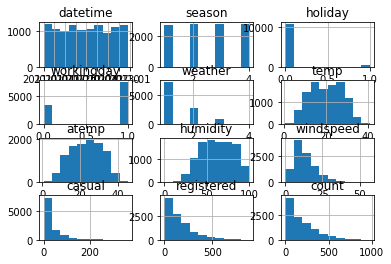

In [19]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [20]:
# create a new feature
train["year"] = train.datetime.dt.year
train["month"] = train.datetime.dt.month
train["day"] = train.datetime.dt.day
train.drop(["datetime"], axis=1, inplace=True)

test["year"] = test.datetime.dt.year
test["month"] = test.datetime.dt.month
test["day"] = test.datetime.dt.day
test.drop(["datetime"], axis=1, inplace=True)

train.head()
test.head()

season  holiday  workingday  weather   temp   atemp  humidity  windspeed  \
0       1        0           1        1  10.66  11.365        56    26.0027   
1       1        0           1        1  10.66  13.635        56     0.0000   
2       1        0           1        1  10.66  13.635        56     0.0000   
3       1        0           1        1  10.66  12.880        56    11.0014   
4       1        0           1        1  10.66  12.880        56    11.0014   

   year  month  day  
0  2011      1   20  
1  2011      1   20  
2  2011      1   20  
3  2011      1   20  
4  2011      1   20

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [21]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [22]:
# View are new feature
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  int64   
 2   workingday  10886 non-null  int64   
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   casual      10886 non-null  int64   
 9   registered  10886 non-null  int64   
 10  count       10886 non-null  int64   
 11  year        10886 non-null  int64   
 12  month       10886 non-null  int64   
 13  day         10886 non-null  int64   
dtypes: category(2), float64(3), int64(9)
memory usage: 1.0 MB


array([[<AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>],
       [<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'day'}>]], dtype=object)

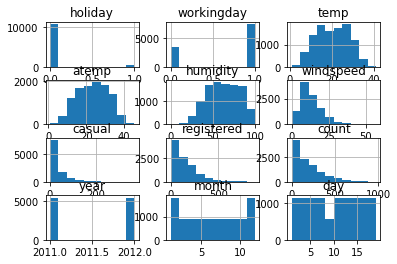

In [23]:
# View histogram of all features again now with the hour feature
train.hist()

## Step 5: Rerun the model with the same settings as before, just with more features

In [24]:
predictor_new_features = TabularPredictor(label="count", learner_kwargs={'ignored_columns': ["casual", "registered"]}).fit(
    train_data=train, time_limit=600, presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220906_090246/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220906_090246/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns

In [25]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -126.401655       9.359396  550.375441                0.000951           0.394125            3       True         16
1        LightGBMXT_BAG_L2 -126.969479       8.006691  417.190785                0.255021          22.724468            2       True         10
2          CatBoost_BAG_L2 -127.208354       7.850110  446.858382                0.098440          52.392066            2       True         13
3     ExtraTreesMSE_BAG_L2 -127.442100       8.337582  403.155909                0.585912           8.689593            2       True         14
4   NeuralNetFastAI_BAG_L2 -127.446606       8.284303  445.439455                0.532633          50.973139            2       True         15
5          LightGBM_BAG_L2 -127.565329       7.886439  415.202049         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -154.03108914279713,
  'KNeighborsDist_BAG_L1': -154.1833658838154

In [26]:
# Remember to set all negative values to zero
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    84.512817
1    73.177231
2    73.177231
3    77.358337
4    77.358337
Name: count, dtype: float32

In [27]:
# Same submitting predictions
submission_new_features = pd.read_csv('./sampleSubmission.csv', parse_dates=["datetime"])
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

#### New Score of `1.33069`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [32]:
predictor_new_hpo = TabularPredictor(label="count", learner_kwargs={'ignored_columns': ["casual", "registered"]}).fit(
    train_data=train, time_limit=600, num_bag_folds=5, num_bag_sets=1, num_stack_levels=1, presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220906_094447/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220906_094447/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns:

In [33]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -125.961038       9.252549  508.586807                0.000832           0.459194            3       True         20
1        LightGBMXT_BAG_L2 -127.028028       8.029354  391.468947                0.144076          12.906557            2       True         13
2          CatBoost_BAG_L2 -127.185308       7.975564  414.079612                0.090286          35.517222            2       True         16
3   NeuralNetFastAI_BAG_L2 -127.189019       8.305846  440.631626                0.420568          62.069236            2       True         18
4     ExtraTreesMSE_BAG_L2 -127.204217       8.482477  387.131387                0.597199           8.568997            2       True         17
5          LightGBM_BAG_L2 -127.959143       8.002653  392.229761         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFa

In [34]:
# Remember to set all negative values to zero
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo.iloc[predictions_new_hpo.lt(0)] = 0

In [35]:
# Same submitting predictions
submission_new_hpo = pd.read_csv('./sampleSubmission.csv', parse_dates=["datetime"])
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

#### New Score of `1.33439`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

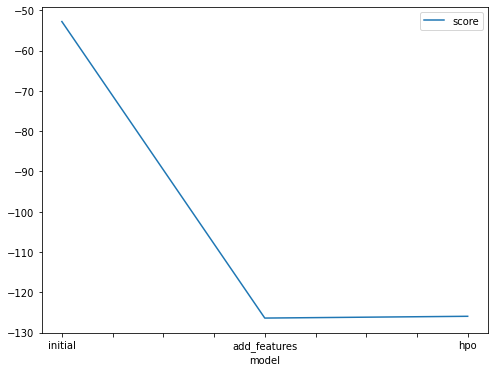

In [41]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-52.785956, -126.401655, -125.961038]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')


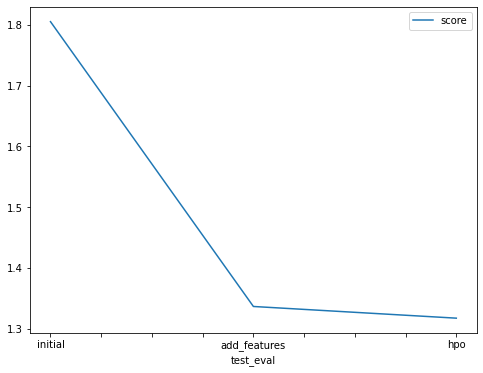

In [39]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80552, 1.33654, 1.31730]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [ ]:
# The 3 hyperparameters we tuned with the kaggle score as the result

pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "num_bag_folds": [0, 0, 5],
    "num_bag_sets": [20, 20, 1],
    "num_stack_levels": [0, 0, 1],
    "score": [1.39539, 1.33199, 1.30937]
})